<a href="https://colab.research.google.com/github/jiachoi-ds/Reinforcement-Learning/blob/Ji-Hyeon-Yoo/FinalProject.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [2]:
!pip install stable-baselines3[extra]
!pip install shimmy

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 187.2/187.2 kB 13.8 MB/s eta 0:00:00


In [3]:
import numpy as np
import gym
import random
import pickle
import matplotlib.pyplot as plt

from gym import spaces

from stable_baselines3 import PPO
from stable_baselines3.common.env_util import make_vec_env
from stable_baselines3.common.vec_env import DummyVecEnv



Gym has been unmaintained since 2022 and does not support NumPy 2.0 amongst other critical functionality.
Please upgrade to Gymnasium, the maintained drop-in replacement of Gym, or contact the authors of your software and request that they upgrade.
See the migration guide at https://gymnasium.farama.org/introduction/migration_guide/ for additional information.
/usr/local/lib/python3.12/dist-packages/jupyter_client/session.py:203: DeprecationWarning: datetime.datetime.utcnow() is deprecated and scheduled for removal in a future version. Use timezone-aware objects to represent datetimes in UTC: datetime.datetime.now(datetime.UTC).
  return datetime.utcnow().replace(tzinfo=utc)
/usr/local/lib/python3.12/dist-packages/jupyter_client/session.py:203: DeprecationWarning: datetime.datetime.utcnow() is deprecated and scheduled for removal in a future version. Use timezone-aware objects to represent datetimes in UTC: datetime.datetime.now(datetime.UTC).
  return datetime.utcnow().replace(tzinfo=

In [24]:
class MyEnv(gym.Env):

    metadata = {"render.modes": ["human"]}

    def __init__(self, K_min=200.0, K_max=2000.0, max_steps=200):
        super().__init__()

        # state(obs): q, L, C, T, X, xI_cur, xH_cur
        # there are no done
        obs_low = np.array([0.0,    0.0,   0.0,   0.0,   0.0, 0.0, 0.0], dtype=np.float32)
        obs_high = np.array([1.0, 50000., 50000., 20000., 50.0, 1.0, 1.0], dtype=np.float32)
        self.observation_space = spaces.Box(obs_low, obs_high, dtype=np.float32) # define for obs space, and for using PPO (caution: string match)

        # Government Cap
        self.K_min = K_min
        self.K_max = K_max

        #**self.action_space = spaces.Box(low=np.array([self.K_min], dtype=np.float32), high=np.array([self.K_max], dtype=np.float32), dtype=np.float32) # define for action space, and using PPO (caution: string match)
        self.action_space = spaces.Box(low=-1.0, high=1.0, shape=(1,), dtype=np.float32)

        # weight parameter alpha for compute UG
        self.alpha_1 = 1.0 #for insurance company
        self.alpha_2 = 1.0 #for homeowner

        self.m = 250.0 # risk premium for Insurance Company

        # state transition hyper parameters
        self.q_bar = 0.04 #default(usual expect) probability for fire probability
        self.L_bar = 10000.0 #default(usual expect) loss when fire outbreak
        self.C_bar = 2500.0 #default(usual expect) return from Insurance company

        # momentum(mean-reversion) coefficient
        self.phi_q = 0.9
        self.phi_L = 0.9
        self.phi_C = 0.9

        # noise scaling parameter(effect on momentum)
        self.sigma_q = 0 #0.002
        self.sigma_L = 0 #500.0
        self.sigma_C = 0 #100.0

        ## noise from gaussian distribution
        # self.noise_q = random.randomm()
        # self.noise_L = random.randomm()
        # self.noise_C = random.randomm()
        ## >> redundant while using step()!

        ## dynamic parameter of market status. Especcially for 'when a insurance company puts a product on the market'
        # # it'll change while step() goes on, just initial settings as float.
        # self.delta_C_pos = 150.0
        # self.delta_C_neg = 80.0
        ## >> no use while using step()

        # extra management cost increase ratio for Insurance company.
        self.gamma_T = 5.0

        # satisfying differential ratio parameter for home owner
        self.gamma_X = 1.0
        self.rho_bar = 0.5 # goal coverage for home owner, never set as 1

        self.max_steps = max_steps
        self.step_count = 0

        self.state = None # set whatever you want as initial. I'll just leave it to reset()
        self.last_info = {}  # to use baseline


        self.cum_reward = 0.0 # total reward for each episode
        self.cum_reward_list = []

    def seed(self, seed=None):
        np.random.seed(seed)

    def reset(self):
        q_0 = np.clip(np.random.normal(self.q_bar, 0.005), 0.001, 0.2)
        L_0 = np.random.normal(self.L_bar, 1000.0)
        C_0 = np.random.normal(self.C_bar, 300.0)
        T_0 = 50.0
        X_0 = 300.0
        xI_cur = 0.0 # 0.0 or 1.0
        xH_cur = 0.0 # 0.0 or 1.0

        self.state = np.array( [q_0, L_0, C_0, T_0, X_0, xI_cur, xH_cur], dtype=np.float32)
        self.step_count = 0
        self.last_info = {}

        self.cum_reward=0.0

        return self.state

    def step(self, action):
        self.step_count += 1
        # _cur : current state indexing label
        # _next: next state indexing label

        # action: government cap
        #**K_cur = float(np.clip(action[0], self.K_min, self.K_max))
        a = float(np.clip(action[0], -1.0, 1.0))
        K_cur = self.K_min + (a + 1.0) * 0.5 * (self.K_max - self.K_min)

        # unpack the state
        q_cur, L_cur, C_cur, T_cur, X_cur, xI_cur, xH_cur = self.state #set xI and xH as previousone for easy-comprehension

        # insurer premium decision (capped)
        P_cur = min(K_cur, q_cur * C_cur + self.m)

        # homeowner decision making (buy or not)
        desire_buy = 1.0 if P_cur <= (q_cur * C_cur + X_cur) else 0.0

        # expected profit for insurance company when homeowner buys
        exp_profit_if_buy = desire_buy * (P_cur - q_cur * C_cur) - T_cur

        if exp_profit_if_buy >= 0:
            xI_next = 1.0
            xH_next = desire_buy  # homeowner actually buys if it wanted to
        else:
            xI_next = 0.0
            xH_next = 0.0  # no insurer -> no purchase

        # compute utilities
        U_I = xI_next * (xH_next * (P_cur - q_cur * C_cur) - T_cur)
        U_H = xI_next * xH_next * (q_cur * C_cur - P_cur + X_cur) - q_cur * L_cur
        reward = self.alpha_1 * U_I + self.alpha_2 * U_H

        reward=reward/1000.0 #scaling for adapt value loss

        #extra reward
        reward += 0.5 * xI_next
        reward += 0.2 * xH_next

        self.cum_reward+=reward

        # state transition
        # fire probability (mean reversion + noise)
        q_next = self.phi_q * q_cur + (1 - self.phi_q) * self.q_bar + self.sigma_q * np.random.randn()
        q_next = float(np.clip(q_next, 0.001, 0.5))

        # loss size
        L_next = self.phi_L * L_cur + (1 - self.phi_L) * self.L_bar + self.sigma_L * np.random.randn()
        L_next = float(max(100.0, L_next))

        # cost of homeowner
        C_base = self.phi_C * C_cur + (1 - self.phi_C) * self.C_bar

        # market-response scale parameter

        up_ratio = 0.05 # no entry -> cost up by 5%
        down_ratio = 0.03 # entry -> cost down by 3%

        if xI_next == 0.0:
            C_next = C_base + up_ratio * C_cur
        else:
            C_next = C_base - down_ratio * C_cur

        # optional stochastic noise on C
        if self.sigma_C > 0.0:
            C_next += self.sigma_C * np.random.randn()

        C_next = float(max(100.0, C_next))

        # operating cost
        T_next = T_cur + self.gamma_T * (1.0 - xI_next)

        # psychological utility
        X_next = X_cur + self.gamma_X * (xH_next - self.rho_bar)
        X_next = float(np.clip(X_next, 0.0, 50.0))

        # pack next state
        self.state = np.array(
            [q_next, L_next, C_next, T_next, X_next, xI_next, xH_next],
            dtype=np.float32
        )

        # truncation case
        done = self.step_count >= self.max_steps
        #truncated=False

        self.last_info = {
            "K_t": K_cur,
            "P_t": P_cur,
            "xI_next": xI_next,
            "xH_next": xH_next,
            "U_I": U_I,
            "U_H": U_H,
            "exp_profit_if_buy": exp_profit_if_buy,
        }

        if done:
            self.cum_reward_list.append(self.cum_reward)

        # to render the state transition.
        if not hasattr(self, "history"):
            self.history = []
        self.history.append([K_cur, P_cur, xI_next, xH_next, q_cur, C_cur, X_cur])

        return self.state, float(reward), done, self.last_info

    def render(self, mode="human"):

        if len(self.cum_reward_list) == 0:
            return

        plt.figure(figsize=(6, 4))
        plt.plot(self.cum_reward_list, marker="o")
        plt.xlabel("Episode")
        plt.ylabel("Total Reward")
        plt.title("Episode Total Reward over time")
        plt.grid(True)
        plt.show()

        # total reward
        if not hasattr(self, "history") or len(self.history) == 0:
            return

        history = np.array(self.history)
        steps = np.arange(len(history))

        K_vals = history[:, 0]
        P_vals = history[:, 1]
        xI_vals = history[:, 2]
        xH_vals = history[:, 3]
        q_vals = history[:, 4]
        C_vals = history[:, 5]
        X_vals = history[:, 6]

        # K_t, P_t
        fig, (ax_left, ax_right) = plt.subplots(1, 2, figsize=(10, 4), sharex=True)

        ax_left.plot(steps, K_vals, color="tab:blue")
        ax_left.set_title("K_t (cap)")
        ax_left.set_xlabel("Step")
        ax_left.set_ylabel("K_t")
        ax_left.grid(True)

        ax_right.plot(steps, P_vals, color="tab:orange")
        ax_right.set_title("P_t (premium)")
        ax_right.set_xlabel("Step")
        ax_right.set_ylabel("P_t")
        ax_right.grid(True)

        plt.tight_layout()
        plt.show()

        # xI, xH : 1 row, 2 columns
        fig, (ax_l, ax_r) = plt.subplots(1, 2, figsize=(10, 3), sharex=True)

        ax_l.step(steps, xI_vals, where="post", color="tab:green", label="xI_next")
        ax_l.set_title("xI_next (insurer entry)")
        ax_l.set_xlabel("Step")
        ax_l.set_ylabel("xI")
        ax_l.set_ylim(-0.1, 1.1)
        ax_l.grid(True)
        ax_l.legend(loc="upper right")

        ax_r.step(steps, xH_vals, where="post", color="tab:red", label="xH_next")
        ax_r.set_title("xH_next (homeowner buy)")
        ax_r.set_xlabel("Step")
        ax_r.set_ylim(-0.1, 1.1)
        ax_r.grid(True)
        ax_r.legend(loc="upper right")

        plt.tight_layout()
        plt.show()

        # market dynamics: C, X (left) + q (right)
        fig, ax1 = plt.subplots(figsize=(9, 4))
        ax1.plot(steps, C_vals, label="C_t (cost)", color="tab:brown")
        ax1.plot(steps, X_vals, label="X_t (psychological)", color="tab:pink")
        ax1.set_xlabel("Step")
        ax1.set_ylabel("C_t / X_t")
        ax1.grid(True)

        ax2 = ax1.twinx()
        ax2.plot(steps, q_vals, label="q_t (fire prob.)", color="tab:purple", linestyle="--")
        ax2.set_ylabel("q_t")
        ax2.set_ylim(0.0, 0.1)
        ax2.legend(loc="upper right")

        h1, l1 = ax1.get_legend_handles_labels()
        h2, l2 = ax2.get_legend_handles_labels()
        ax2.legend(h1 + h2, l1 + l2, loc="upper right")

        plt.title("Market dynamics")
        plt.tight_layout()
        plt.show()

In [25]:
env = MyEnv()
obs = env.reset()

num_steps = 10
for t in range(num_steps):
    action = env.action_space.sample()
    next_obs, reward, done,_= env.step(action)

    print(f"\n[STEP {t+1}]")
    print(f"Action (K): {action}")
    print(f"Reward: {reward:.3f}")
    print(f"Next state: {next_obs}")

    if done:
        print("\nEpisode finished early (max_steps reached).")
        break




[STEP 1]
Action (K): [-0.05649581]
Reward: 0.634
Next state: [3.2428328e-02 1.0010200e+04 2.8358281e+03 5.0000000e+01 5.0000000e+01
 1.0000000e+00 1.0000000e+00]

[STEP 2]
Action (K): [0.44546074]
Reward: -0.325
Next state: [3.3185493e-02 1.0009180e+04 2.9440369e+03 5.5000000e+01 4.9500000e+01
 0.0000000e+00 0.0000000e+00]

[STEP 3]
Action (K): [0.24304004]
Reward: -0.332
Next state: [3.3866942e-02 1.0008262e+04 3.0468350e+03 6.0000000e+01 4.9000000e+01
 0.0000000e+00 0.0000000e+00]

[STEP 4]
Action (K): [0.22481842]
Reward: -0.339
Next state: [3.4480248e-02 1.0007436e+04 3.1444932e+03 6.5000000e+01 4.8500000e+01
 0.0000000e+00 0.0000000e+00]

[STEP 5]
Action (K): [0.9078318]
Reward: -0.345
Next state: [3.5032220e-02 1.0006691e+04 3.2372683e+03 7.0000000e+01 4.8000000e+01
 0.0000000e+00 0.0000000e+00]

[STEP 6]
Action (K): [0.04946091]
Reward: -0.351
Next state: [3.5528999e-02 1.0006022e+04 3.3254050e+03 7.5000000e+01 4.7500000e+01
 0.0000000e+00 0.0000000e+00]

[STEP 7]
Action (K): [

Using cuda device
-----------------------------
| time/              |      |
|    fps             | 857  |
|    iterations      | 1    |
|    time_elapsed    | 1    |
|    total_timesteps | 1024 |
-----------------------------
------------------------------------------
| time/                   |              |
|    fps                  | 665          |
|    iterations           | 2            |
|    time_elapsed         | 3            |
|    total_timesteps      | 2048         |
| train/                  |              |
|    approx_kl            | 0.0035198987 |
|    clip_fraction        | 0.0241       |
|    clip_range           | 0.2          |
|    entropy_loss         | -1.42        |
|    explained_variance   | 0.0253       |
|    learning_rate        | 0.0003       |
|    loss                 | 1.08         |
|    n_updates            | 10           |
|    policy_gradient_loss | -0.00118     |
|    std                  | 1.01         |
|    value_loss           | 8.43         

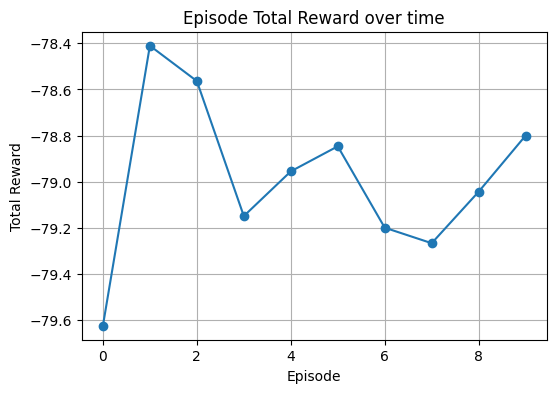

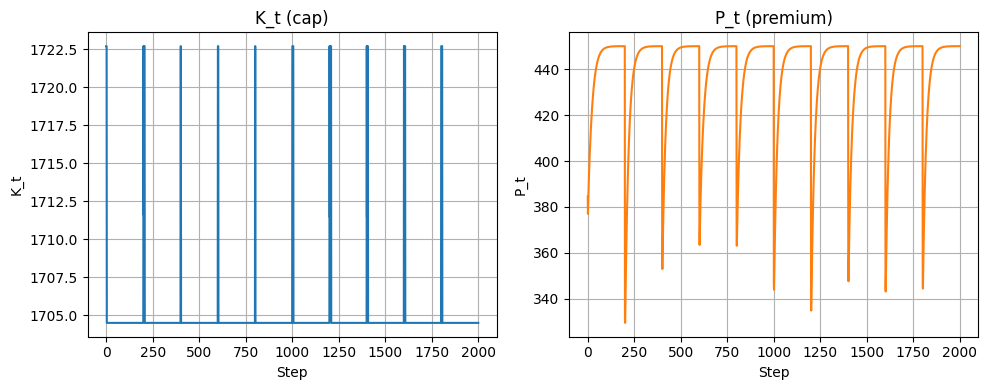

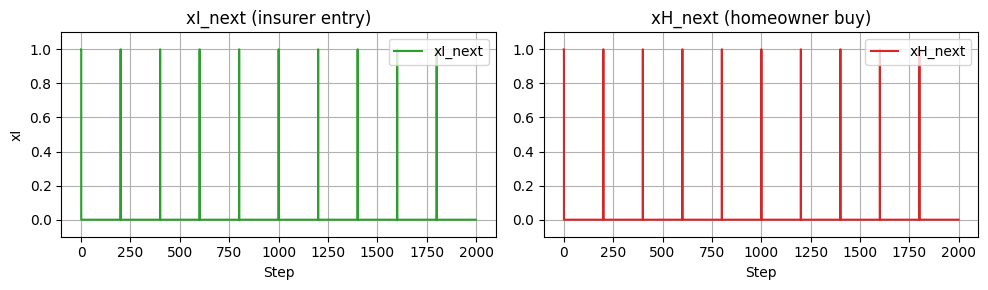

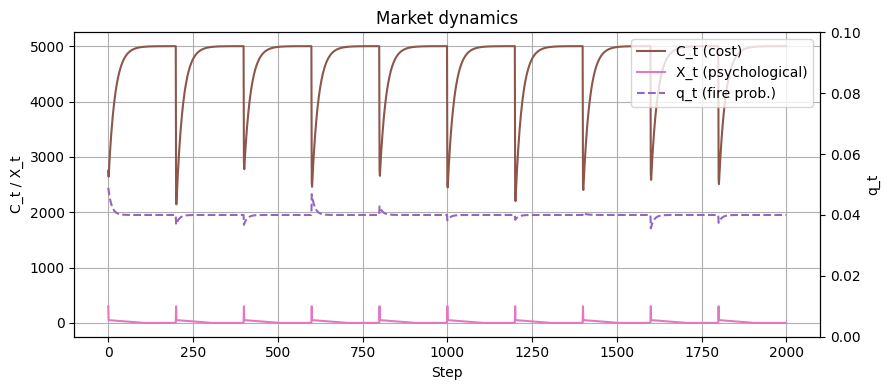

In [26]:
env = DummyVecEnv([lambda: MyEnv()])

# reference using baseline - ppo
# https://stable-baselines3.readthedocs.io/en/master/modules/ppo.html

# use PPO
model = PPO(policy="MlpPolicy", env=env,verbose=1,learning_rate=3e-4, n_steps=1024, batch_size=64, n_epochs=10, gamma=0.99, clip_range=0.2, ent_coef=0.01)

model.learn(total_timesteps=100_000)

model.save("ppo_insurance_policy")
print("ppo model has saved")


test_env = MyEnv()
n_eval_episodes = 10

for ep in range(n_eval_episodes):
    obs = test_env.reset()
    done = False
    while not done:
        action, _ = model.predict(obs, deterministic=True)
        obs, reward, done, info = test_env.step(action)

test_env.render()